# RR Lyrae Period-Luminosity

Eric Bellm
January 2020

In this exercise we'll use real data from a variety of surveys to learn more about the relationship between an RR Lyrae variable's period and its luminosity.

In [191]:
%matplotlib inline
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.timeseries import TimeSeries, LombScargle
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from astroquery.ipac.irsa.irsa_dust import IrsaDust
import matplotlib.pyplot as plt

## 1. Finding the Period of an RR Lyrae star

We begin by loading the ZTF lightcurve of a previously-identified RR Lyrae star.  We've pre-written this function for you.

In [27]:
def load_ztf_lc(filename):
    """Load a ZTF parquet lightcurve saved by `ztf_query`.
    
    See `ZTF_RRLyrae_data.ipynb` for data retrieval.
    
    Parameters
    ----------
    filename : string
        path to a parquet file saved by `ztf_query`
        
    Returns
    -------
    tbl : `astropy.timeseries.TimeSeries`
        lightcurve 
    mean_ra : `float`
        mean right ascension of the source
    mean_dec : `float`
        mean declination of the source
    """
    
    tbl = Table.read(filename)
    
    # exclude flagged data
    tbl = tbl[tbl['catflags'] == 0]
    
    mean_ra = np.mean(tbl['ra'])
    mean_dec = np.mean(tbl['dec'])
    
    return TimeSeries(time=Time(tbl['hjd'],format='jd'),data=tbl[['mag','magerr','filtercode']]), mean_ra, mean_dec

We load it into an astropy [`Timeseries`](https://docs.astropy.org/en/stable/timeseries/index.html).

In [134]:
ts, mean_ra, mean_dec = load_ztf_lc('../data/ztf_rrl_lightcurves/12.parquet')
ts

time,mag,magerr,filtercode
Time,float64,float64,str2
2458203.8852543235,17.1999512,0.0184876267,zg
2458203.9138199687,17.1843719,0.0183547549,zg
2458204.916476126,17.0556793,0.0173353087,zg
2458204.9394050865,17.0869713,0.0175707769,zg
2458204.959220457,17.113905,0.0177796986,zg
2458204.964672015,17.089777,0.0175922625,zg
2458204.965586341,17.0833168,0.0175428726,zg
2458204.999013193,17.1397419,0.0179857016,zg
2458204.999927622,17.1245728,0.0178640857,zg


In [135]:
print(mean_ra, mean_dec)

245.55715820833677 44.55899377304023


Which filters are present?

In [136]:
set(ts['filtercode'])

{'zg', 'zi', 'zr'}

Let's assign default colors to these filters.

In [137]:
colors = {'zg':'C0',
          'zr':'C1',
          'zi':'C3'}

Next, let's plot the lightcurve.

In [138]:
def plot_lc(ts):
    """Plot a ZTF lightcurve.
    
    Parameters
    ----------
    ts :  `astropy.timeseries.TimeSeries`
        ZTF lightcurve
        
    """
    
    fig = plt.figure() 
    
    # loop over the available filters
    for filt in set(ts['filtercode']):
        # select the rows that correspond to that filter
        wfilt = ts['filtercode'] == filt
        plt.errorbar(ts[wfilt].time.mjd,ts[wfilt]['mag'],ts[wfilt]['magerr'],
                     label=filt,fmt='.',ls='none',color=colors[filt])
        
    plt.legend()
    plt.xlabel('MJD (days)')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis() # smaller magnitudes are brighter--flip the y axis

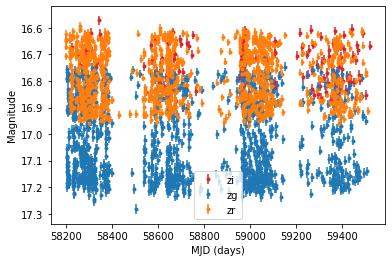

In [139]:
plot_lc(ts)

Astropy's period finding expects the inputs to be in a single filter.  We define a selector which identifies the rows with r-band data:

In [140]:
wr = ts['filtercode'] == 'zr'

Here's an example of how to apply it:

In [141]:
ts[wr]['filtercode']

zr
zr
zr
zr
zr
zr
zr
zr
zr
zr
zr


Now for the exercise:

* Compute the Lomb-Scargle periodogram for the r-band lightcurve using the astropy [`LombScargle`](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) class.
* Plot the resulting periodogram (frequency vs. power).  Label your axes.
* Identify the best period from the periodogram
* Plot the phase-folded lightcurve (in all filters) for this period.

In [142]:
ls = LombScargle.from_timeseries(ts[wr],'mag','magerr')#,fit_mean='True',nterms=3)
frequency, power = ls.autopower(method='chi2')

Text(0, 0.5, 'Power')

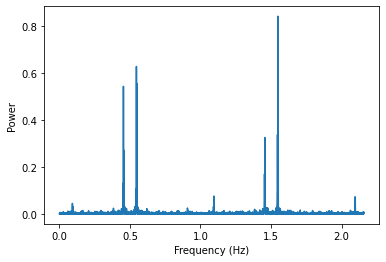

In [143]:
plt.plot(frequency, power) 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

In [144]:
ls.false_alarm_probability(power.max(), method='baluev')  

<Quantity 0.>

In [145]:
best_frequency = frequency[np.argmax(power)]
best_period = 1/best_frequency
print(best_period)
#t_fit = np.linspace(ts.time.min(), ts.time.max())
#y_fit = ls.model(t_fit, best_frequency)

0.645661786204658 d


In [146]:
ts_fold = ts.fold(period=best_period, normalize_phase=True, wrap_phase=1)

In [147]:
def plot_phased_lc(ts):
    """Plot a phase-folded ZTF lightcurve.
    
    Parameters
    ----------
    ts :  `astropy.timeseries.TimeSeries`
        ZTF lightcurve
        
    """
    
    fig = plt.figure()
       
    
    # loop over the available filters
    for filt in set(ts['filtercode']):
        # select the rows that correspond to that filter
        wfilt = ts['filtercode'] == filt
        plt.errorbar(ts[wfilt].time,ts[wfilt]['mag'],ts[wfilt]['magerr'],
                     label=filt,fmt='.',ls='none')
        
    plt.legend()
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()

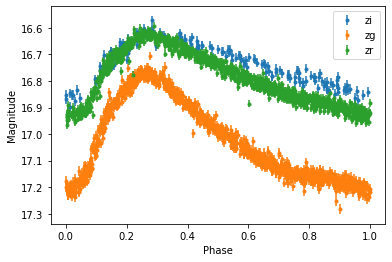

In [148]:
plot_phased_lc(ts_fold)

## 2. Plot Period-Luminosity relation

If we computed a large number of periods for RR Lyrae for which we knew their distances, we could determine if there is a relationship between period and luminosity.  Computing so many periods is a lot of work, so we'll instead use a recently-published catalog from [Huang and Koposov 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.510.3575H/abstract).  We will read in their catalog directly:

In [17]:
tbl = Table.read('../data/rrl_main_cat.csv')

In [18]:
tbl.columns

<TableColumns names=('objid','source_id','ra','dec','prob_rrl','best_period','ebv','distance','mean_g','mean_r','mean_i','phot_g_mean_mag','amp_1_r','phi_1_r','amp_1_g','phi_1_g','amp_1_i','phi_1_i','amp_2_r','phi_2_r','amp_2_g','phi_2_g','amp_2_i','phi_2_i','amp_3_r','phi_3_r','amp_3_g','phi_3_g','amp_3_i','phi_3_i','ngooddet_g','ngooddet_r','ngooddet_i')>

In [19]:
tbl

objid,source_id,ra,dec,prob_rrl,best_period,ebv,distance,mean_g,mean_r,mean_i,phot_g_mean_mag,amp_1_r,phi_1_r,amp_1_g,phi_1_g,amp_1_i,phi_1_i,amp_2_r,phi_2_r,amp_2_g,phi_2_g,amp_2_i,phi_2_i,amp_3_r,phi_3_r,amp_3_g,phi_3_g,amp_3_i,phi_3_i,ngooddet_g,ngooddet_r,ngooddet_i
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
245101100001850,2323207596351730304,4.34881002091745,-26.7325358431298,0.95,0.621282,0.0177999,35202.5,18.448895,18.263773,--,18.2781,0.310712,-0.42090702,0.4296189,-0.5540015,--,--,0.13699114,1.1193074,0.18674164,1.1728027,--,--,0.077739686,2.9355524,0.111421965,2.6032557,--,--,74,76,0
245101200001823,2323151181956812672,3.44761987859165,-26.7369695263057,0.89,0.363568,0.0223381,20908.6,17.66247,17.58033,--,17.573,0.21442999,2.6106074,0.31068435,2.6765757,--,--,0.025368612,0.7849637,0.04944191,0.691132,--,--,0.02951918,-1.65067,0.016883053,-1.8536656,--,--,80,81,0
245101200006240,2323082286386272640,3.83587158932291,-27.0437438733329,0.99,0.566281,0.021689,19608.2,17.265985,17.059336,--,17.0437,0.24486491,2.5618405,0.34430373,2.4899223,--,--,0.11433268,0.9279561,0.16546234,1.0097619,--,--,0.08503796,-0.7780889,0.113629706,-0.9787848,--,--,79,79,0
245102200002148,2333889115592815616,1.83508756403094,-26.7386565560488,0.97,0.501806,0.0190932,17462.7,17.080528,16.90064,--,17.0114,0.31278467,3.0024025,0.44559923,2.9263508,--,--,0.1482002,2.0833945,0.21522047,2.0611908,--,--,0.11036861,0.81837624,0.18304227,0.821719,--,--,82,80,0
245103100001517,2333944331692281728,0.885322879300275,-26.5988557305232,0.98,0.58118,0.0158643,13775.1,16.47706,16.245916,--,16.2358,0.18669358,-2.1638775,0.2724687,-2.3415463,--,--,0.09654707,-2.277384,0.12579872,-2.3305018,--,--,0.058639035,-2.5625422,0.07181948,-2.9064033,--,--,82,84,0
245103100002038,2334596681389448192,0.268704425294681,-26.6972408543714,0.79,0.613461,0.015369,59100.4,19.55729,19.410467,--,19.4415,0.27695486,-3.0480475,0.37774724,2.9442918,--,--,0.07293855,1.9353324,0.09814847,2.2232306,--,--,0.10155248,1.5703725,0.056697316,1.1640925,--,--,69,71,0
245103100005002,2334605997174339456,0.513661672542887,-26.4832320691523,0.98,0.564039,0.016883,16770.7,16.92302,16.702965,--,16.7005,0.27261832,-1.16433,0.39498895,-1.2606807,--,--,0.12583855,-0.23147184,0.15405215,-0.18731086,--,--,0.10102296,0.54021835,0.12798515,0.6806197,--,--,82,84,0
245103400002219,2333723948330522496,0.781236701419626,-27.5964286741732,0.62,0.369578,0.0151521,46679.8,19.386032,19.282204,--,19.32,0.20522206,2.1804292,0.28291988,2.1789286,--,--,0.024280133,-0.46539125,0.028752318,-0.023957392,--,--,0.010395379,2.9012606,0.021066511,-0.5510438,--,--,70,70,0
245103400003028,2333530262485132160,0.935840957017628,-27.7687603375627,0.67,0.259518,0.015672,12976.3,16.87104,16.746918,--,16.7321,0.17586449,1.8286661,0.265272,1.7957639,--,--,0.03619911,-0.8076371,0.052383453,-0.7969385,--,--,0.02458537,-3.1161103,0.020252746,-1.4001676,--,--,81,83,0


The catalog assigns a probability that the stars they have selected are actually RR Lyrae.  Define a selector to only choose high-confidence RR Lyrae:

In [20]:
wgood = tbl['prob_rrl'] > 0.95

For this exercise:
    
* Compute the absolute r-band magnitude for the high-confidence RR Lyrae using the provided values of distance (in pc) and E(B-V).  (Use A_r = 2.27, so the extinction correction is -2.27 * E(B-V).
* Scatter plot the catalog period vs. absolute magnitude.  Overplot the period-luminosity relation $M_r = -1.6 \log_{10}(\frac{P}{0.6}) + 0.51$, where $P$ is the period in days.
* That period-luminosity relationship is not a great fit--the distances in the table were derived from averages over all three ZTF bands.  Fit a new period-luminosity relationship to the high-confidence RR Lyrae ([`astropy.modeling`](https://docs.astropy.org/en/stable/modeling/index.html) may be helpful) and overplot it.  (Be sure that the `x` coordinate you fit is the log of the period, $\log_{10}(\frac{P}{0.6})$.)

In [185]:
tbl['distance_modulus'] = 5*np.log10(tbl['distance']/10.)
A_r = 2.27
tbl['abs_mag_r'] = tbl['mean_r'] - tbl['distance_modulus'] - A_r * tbl['ebv']

In [188]:
def period_luminosity_r(period):
    return -1.6 * np.log10(period/0.6) + 0.51

Text(0, 0.5, 'Absolute Magnitude')

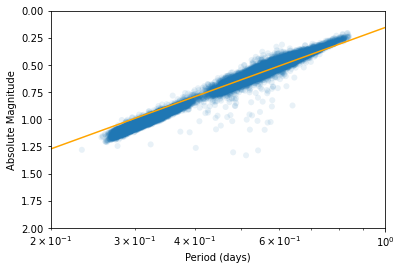

In [189]:
plt.scatter(tbl[wgood]['best_period'],tbl[wgood]['abs_mag_r'],alpha=0.1,edgecolor='none')

ps = np.logspace(-1,1,100)
plt.plot(ps,period_luminosity_r(ps),color='orange')

plt.xscale('log')


plt.ylim(2,0)
plt.xlim(2e-1,1)
plt.xlabel('Period (days)')
plt.ylabel('Absolute Magnitude')

In [24]:
# initialize a linear fitter
fit = fitting.LinearLSQFitter()

# initialize a linear model
line_init = models.Linear1D()
x = np.log10(tbl[wgood]['best_period']/0.6)
y = tbl[wgood]['abs_mag_r']
fitted_line = fit(line_init, x, y)

In [25]:
fitted_line

<Linear1D(slope=-1.86353931, intercept=0.49709249)>

Text(0, 0.5, 'Absolute Magnitude')

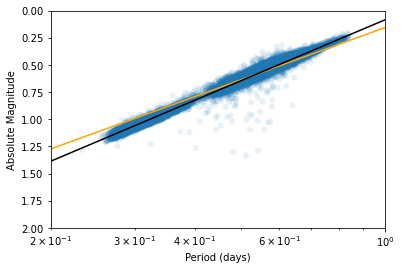

In [26]:
plt.scatter(tbl[wgood]['best_period'],tbl[wgood]['abs_mag_r'],alpha=0.1,edgecolor='none')

ps = np.logspace(-1,1,100)
plt.plot(ps,period_luminosity_r(ps),color='orange')
plt.plot(ps,fitted_line(np.log10(ps/0.6)),color='black')


plt.xscale('log')


plt.ylim(2,0)
plt.xlim(2e-1,1)
plt.xlabel('Period (days)')
plt.ylabel('Absolute Magnitude')

## 3. Estimate distance from the Period-Luminosity relation.

Now let's compute the distance our period-luminosity relationship implies for the RR Lyrae in exercise 1.

In [166]:
ztf_src_sc = SkyCoord(mean_ra, mean_dec, unit='degree')
ztf_src_sc

<SkyCoord (ICRS): (ra, dec) in deg
    (245.55715821, 44.55899377)>

We will need the E(B-V) value at the source location:

In [190]:
ztf_src_ebv = IrsaDust.get_query_table(ztf_src_sc,section='ebv')['ext SFD mean'].value[0]
ztf_src_ebv

0.012

For this exercise:

* Use the period-luminosity relationship and the best-fit period of the source from Exercise 1 to estimate its distance in parsecs.

In [159]:
PL_Mr = fitted_line(np.log10(best_period.to(u.day).value/0.6))
PL_Mr

0.4377316191981557

In [177]:
ztf_mean_r = np.mean(ts[wr]['mag'])
ztf_mean_r

16.788051550705468

In [181]:
distance_mod = ztf_mean_r - PL_Mr - A_r * ztf_src_ebv
distance_mod

16.323079931507312

In [182]:
d = 10**(1+distance_mod/5)
d

18391.45065679902